# Image Denoising

We'll demonstrate the use of a typical encoder–decoder by denoising a very noisy brightfield image of a single particle.

## Simulate a Clean and Noisy Particle

We use `Deeptrack 2.1` to simulate a spherical particle.

In [1]:
import deeptrack as dt
import numpy as np

particle = dt.Sphere(
    position=np.array([0.5, 0.5]) * 64,
    position_unit="pixel",
    # z=0,  ### BM: line can be removed
    radius=500 * dt.units.nm,
    refractive_index=1.45 + 0.02j,
)

We define the optical sysetm to image the particle.

In [2]:
brightfield_microscope = dt.Brightfield(
    wavelength=500 * dt.units.nm,
    NA=1,
    resolution=1 * dt.units.um,
    magnification=10,
    refractive_index_medium=1.33,
    output_region=(0, 0, 64, 64),
    upsample=2,  ### Carlo: present in original version, seems to make a big difference in generalization
)

We create the sample by applying the optical system to the particle.

In [3]:
illuminated_sample = brightfield_microscope(particle)

We create a workflow to simulate _clean_ particle images. We also corrupt them with some Poisson noise to have their _noisy_ version. We join the two workflows into a single simulation pipeline.

In [4]:
import torch

noise = dt.Poisson(snr=lambda: 2.0 + np.random.rand())  ### Carlo: *1 not needed

pipeline = (
    (illuminated_sample >> noise & illuminated_sample)
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

We plot an example of the generated clean and noisy particle. 

For this, we write a simple function to plot the images and add it to `for_denoising.py`:

```python
import matplotlib.pyplot as plt


def plot_image(title, image):
    """Plot a grayscale image with a title."""
    
    plt.imshow(image, cmap="gray")
    plt.title(title, fontsize=24)
    plt.axis("off")
    plt.show()
```

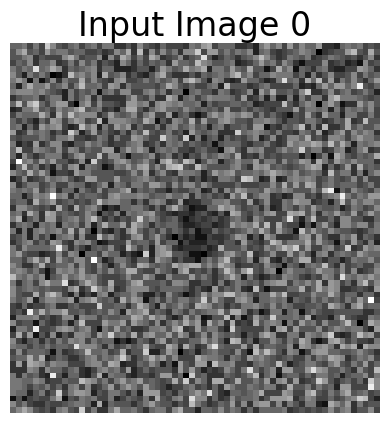

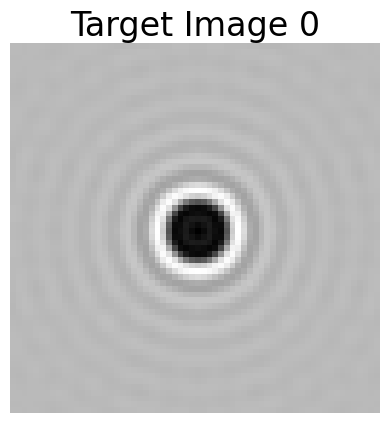

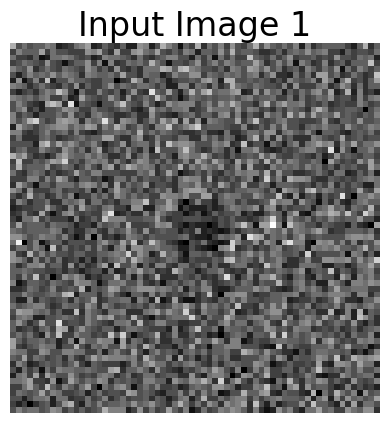

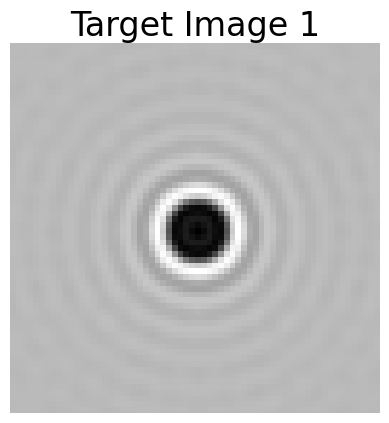

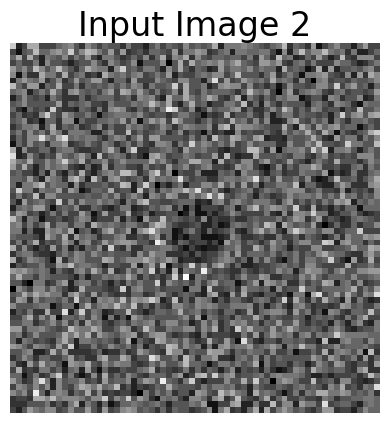

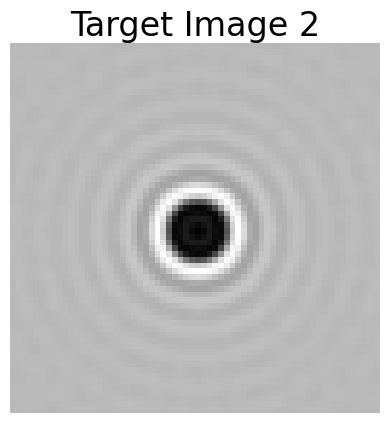

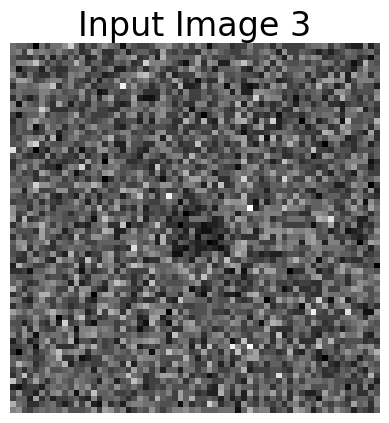

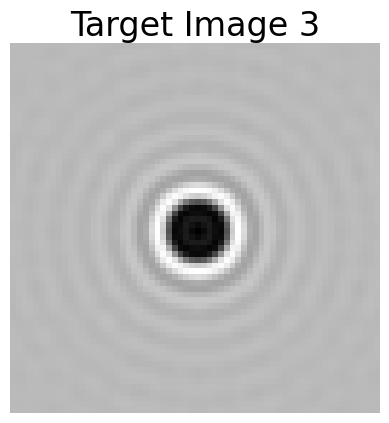

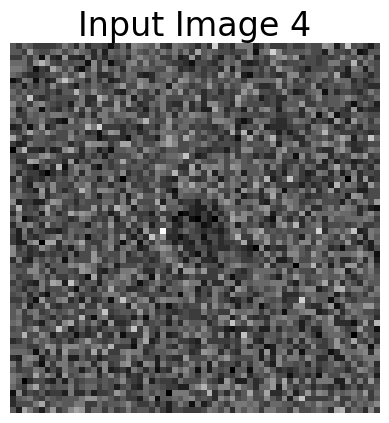

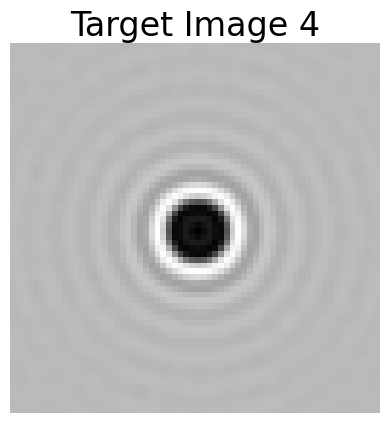

In [5]:
from for_denoising import plot_image

for i in range(5):
    input, target = pipeline.update().resolve()

    plot_image(f"Input Image {i}", input.permute(1, 2, 0))
    plot_image(f"Target Image {i}", target.permute(1, 2, 0))

## Create a Dataset

We define a dataset class that uses the simulation pipeline to generate data. When calling the class, we establish the size of dataset but also introduce the possibility to replace some of the initial data on the fly. In this way we can increase the amount of data that the network sees during the whole training while we keep the dataset size fixed at each epoch, thus establishing a trade off between simulation/training time and generalization ability.

For this we'll create a class and add it to `for_denoising.py`:

```python
class SimulatedDataset(Dataset):
    """Simulated dataset generating pairs of noisy and clean images."""
    
    def __init__(self, pipeline, buffer_size, replace=0):
        """Initialize the dataset."""
        
        self.buffer_size = buffer_size
        self.pipeline = pipeline
        self.replace = replace
        self.images = [pipeline.update().resolve() for _ in range(buffer_size)]

    def __len__(self):
        """Return the size of the dataset buffer."""
        
        return self.buffer_size

    def __getitem__(self, idx):
        """Retrieve a noisy-clean image pair from the dataset."""
        
        if np.random.rand() < self.replace:
            self.images[idx] = self.pipeline.update().resolve()
            
        image_pair = self.images[idx]
        noisy_image, clean_image = image_pair[0], image_pair[1]
        
        return noisy_image, clean_image
```

We create the datasets and the data loaders. These will be used both for the training and for the testing, as each new image is never seen before.

In [6]:
from torch.utils.data import DataLoader
from for_denoising import SimulatedDataset

dataset = SimulatedDataset(pipeline, buffer_size=256, replace=0.2)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

## Define and Train the Autoencoder

We define the autoencoder architecture.

In [7]:
import deeplay as dl

# from torch.nn import Sigmoid ### Carlo: not necessary


autoencoder = dl.ConvolutionalEncoderDecoder2d(
    in_channels=1,
    encoder_channels=[16, 16],
    decoder_channels=[16, 16],
    out_channels=1,
    # out_activation=Sigmoid(),  ### Carlo: already by default
)

print(autoencoder)

ConvolutionalEncoderDecoder2d(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Layer[Identity]()
        (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=16)
      )
      (1-2): 2 x PoolLayerActivationNormalization(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=16)
      )
    )
    (postprocess): Layer[Identity]()
  )
  (decoder): ConvolutionalDecoder2d(
    (preprocess): Layer[Identity]()
    (blocks): LayerList(
      (0-1): 2 x LayerActivationNormalizationUpsample(
        (layer): Layer[Conv2d](in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Laye

We define the loss and the optimizer...

In [8]:
from torch.nn import L1Loss

regressor_template = dl.Regressor(
    model=autoencoder,
    loss=L1Loss(),
    optimizer=dl.Adam(),
)
autoencoder_regressor = regressor_template.create()

print(autoencoder_regressor)

Regressor(
  (loss): L1Loss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): ConvolutionalEncoderDecoder2d(
    (encoder): ConvolutionalEncoder2d(
      (blocks): LayerList(
        (0): PoolLayerActivationNormalization(
          (pool): Identity()
          (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
          (normalization): Identity()
        )
        (1-2): 2 x PoolLayerActivationNormalization(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
          (normalization): Identity()
        )
      )
      (postprocess): Identity()
    )
    (decoder): ConvolutionalDecoder2d(
      (preprocess): Identity()
      (blocks): LayerList(
  

... and start the training.

In [9]:
autoencoder_trainer = dl.Trainer(
    max_epochs=150, accelerator="auto"
)  ### Carlo: 100 seem enough

autoencoder_trainer.fit(autoencoder_regressor, loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/841602/Documents/GitHub/Environments/deeplay_dev_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
2024-02-05 17:02:08.725364: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=150` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


We visualize the autoencoder predictions.

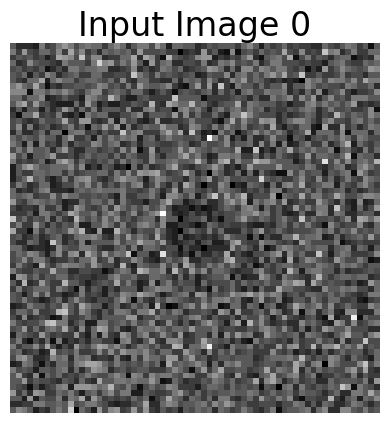

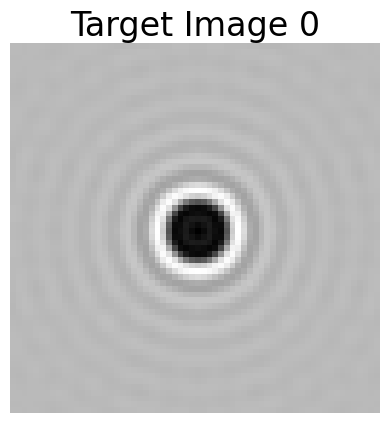

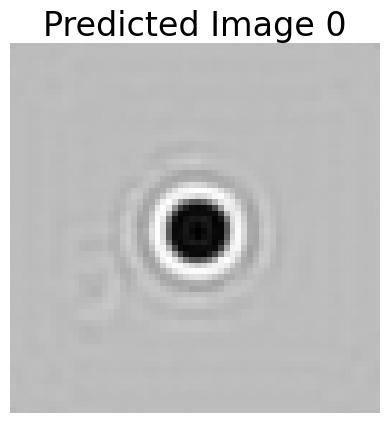

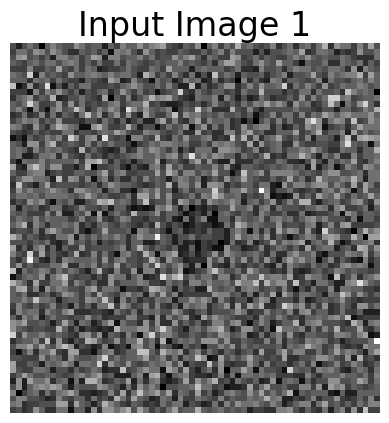

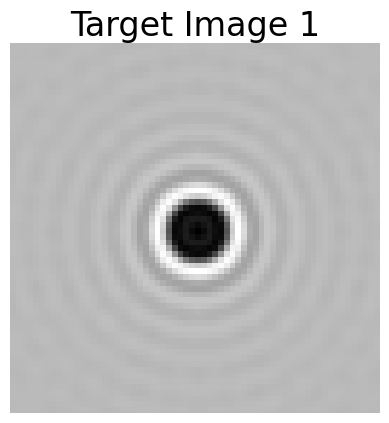

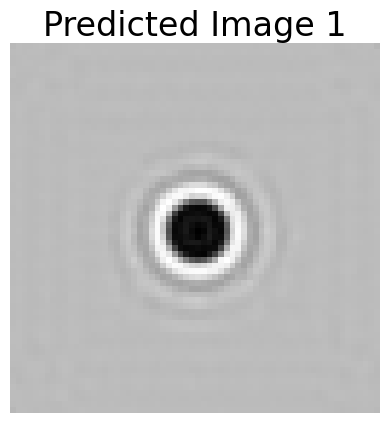

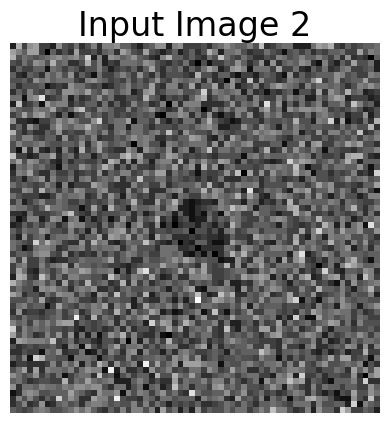

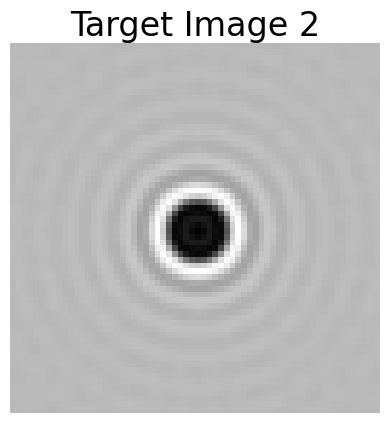

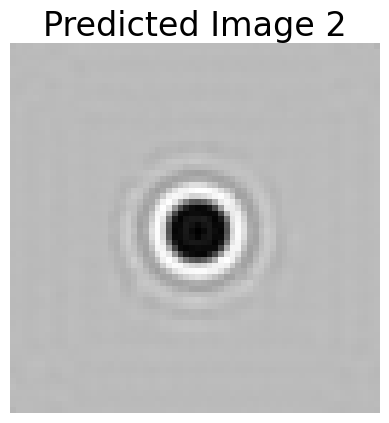

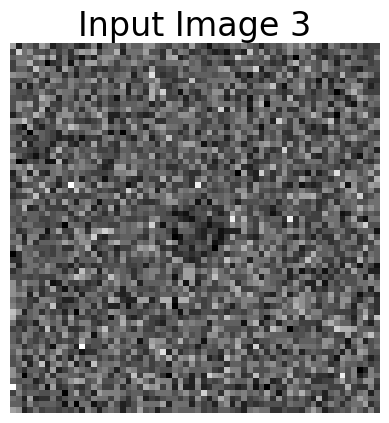

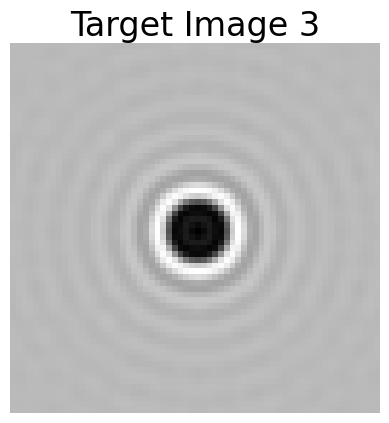

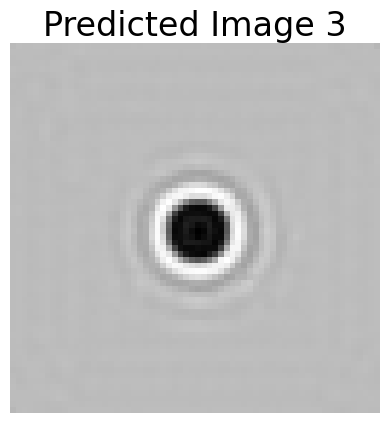

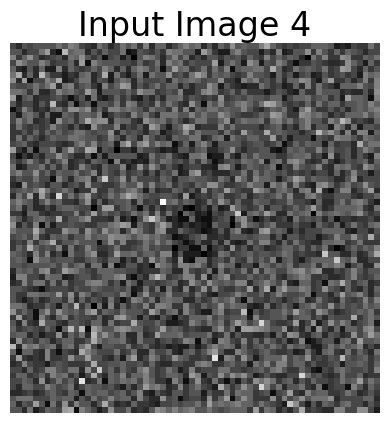

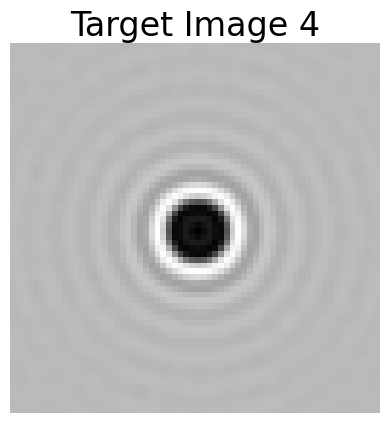

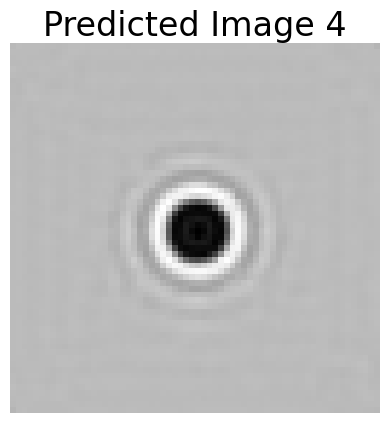

In [10]:
for i in range(5):
    input, target = pipeline.update().resolve()
    predicted = autoencoder_regressor(input.unsqueeze(0)).detach()

    plot_image(f"Input Image {i}", input[0, :, :])
    plot_image(f"Target Image {i}", target[0, :, :])
    plot_image(f"Predicted Image {i}", predicted[0, 0, :, :])

## Check the Absence of Mode Collapse

The training images are very similar. It can be that the autoencoder just learn to provide a centered particle, no matter what is the input (mode collapse). Let's check it out by making a prediction out of noise. 

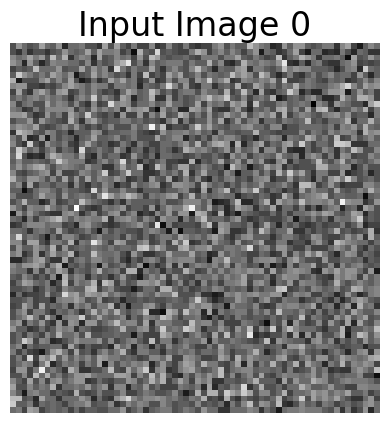

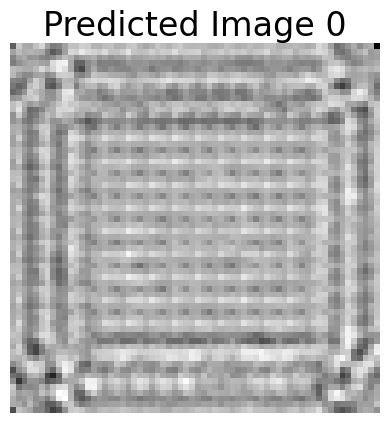

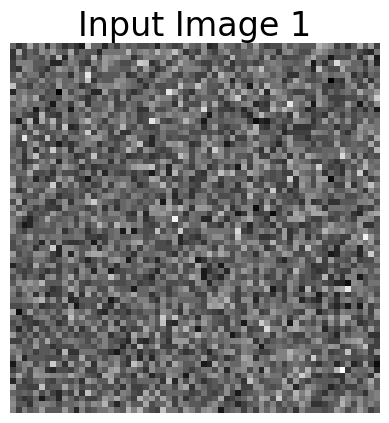

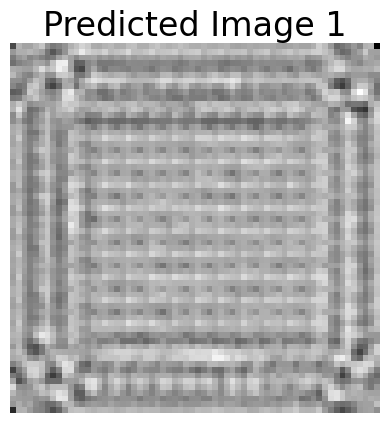

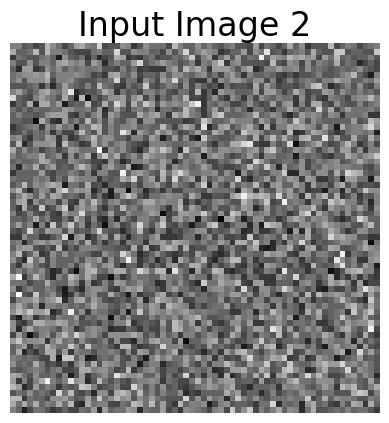

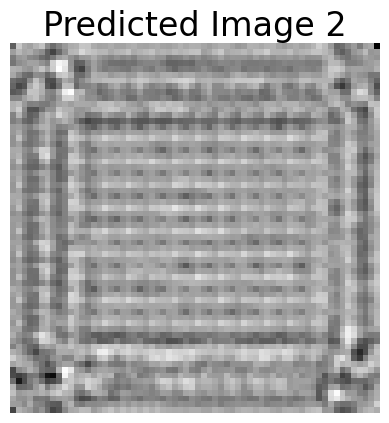

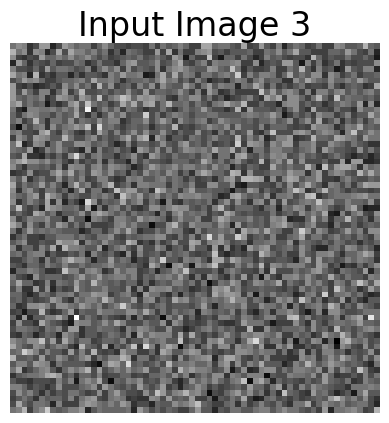

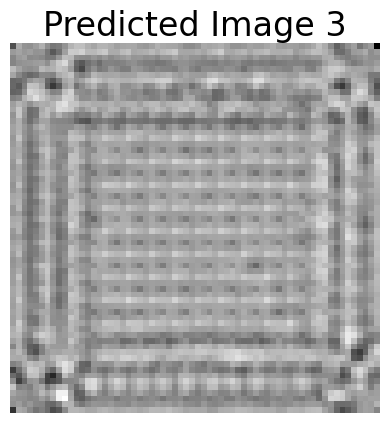

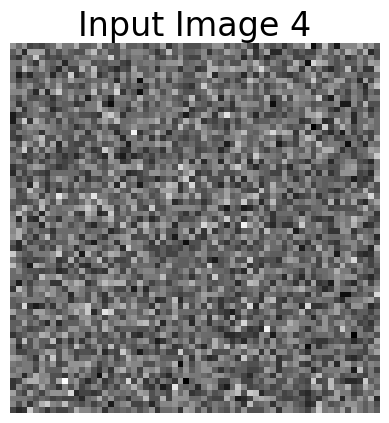

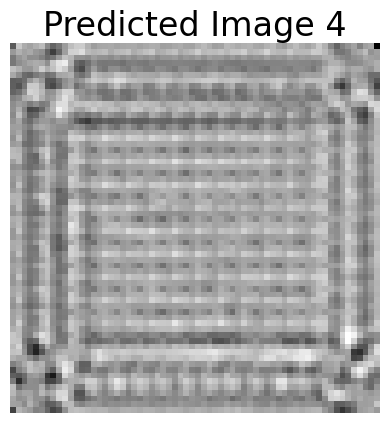

In [11]:
import torch

blank = brightfield_microscope(particle ^ 0)

blank_pipeline = (
    blank
    >> noise
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

for i in range(5):
    blank_image = blank_pipeline.update().resolve()
    blank_predicted = autoencoder_regressor(blank_image.unsqueeze(0)).detach()

    plot_image(f"Input Image {i}", blank_image[0, :, :])
    plot_image(
        f"Predicted Image {i}", np.square(blank_predicted[0, 0, :, :])
    )  ### BM: maybe normalize the visualization so that the images are comparable

## Check Generalization Capabilities

Let's see if the autoencoder is able to generalize its predictions to particles located off center and with different size.

In [12]:
diverse_particle = dt.Sphere(
    position=lambda: np.array([0.2, 0.2] + np.random.rand(2) * 0.6) * 64,
    # z=0,  ### Carlo: not necessary
    position_unit="pixel",
    radius=lambda: 500 * dt.units.nm * (1 + np.random.rand()),
    ### Carlo: changed for consistency
    refractive_index=1.45 + 0.02j,
)

diverse_illuminated_sample = brightfield_microscope(diverse_particle)

### Carlo: changed for consistency
diverse_pipeline = (
    (diverse_illuminated_sample >> noise & diverse_illuminated_sample)
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

# diverse_clean_particle = (
#     diverse_illuminated_sample
#     >> dt.NormalizeMinMax()
#     >> dt.MoveAxis(2, 0)
#     >> dt.pytorch.ToTensor(dtype=torch.float)
# )

# diverse_noisy_particle = (
#     diverse_illuminated_sample
#     >> noise
#     >> dt.NormalizeMinMax()
#     >> dt.MoveAxis(2, 0)
#     >> dt.pytorch.ToTensor(dtype=torch.float)
# )

# diverse_pipeline = (diverse_noisy_particle) & (diverse_clean_particle)

We check the predictions on this more challenging test set.

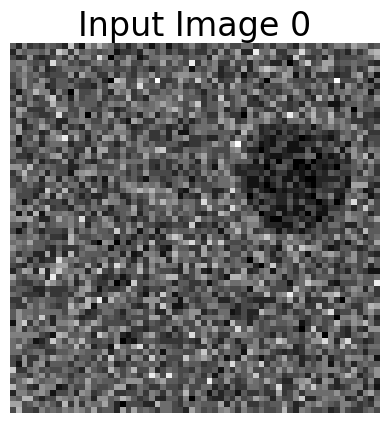

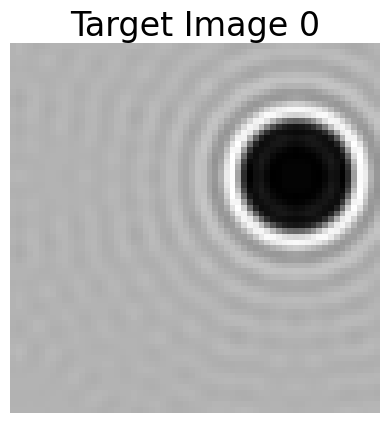

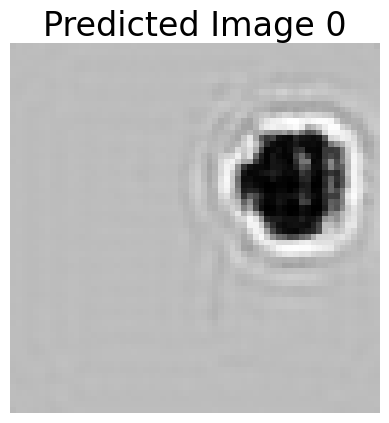

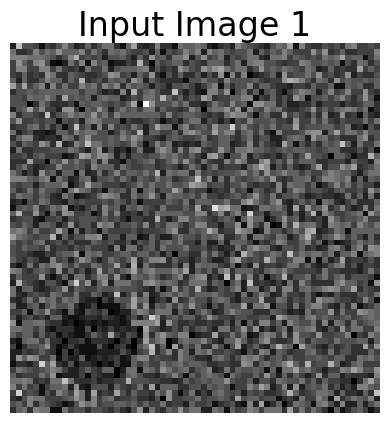

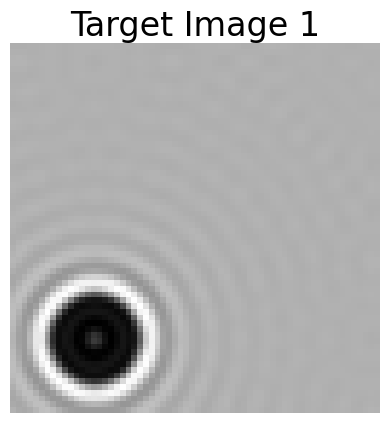

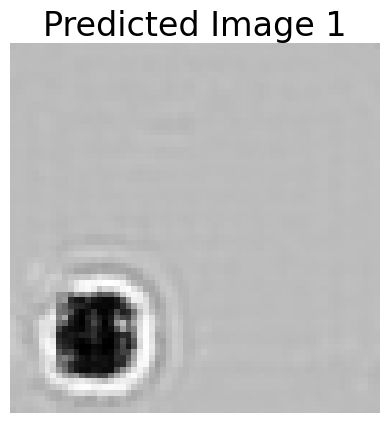

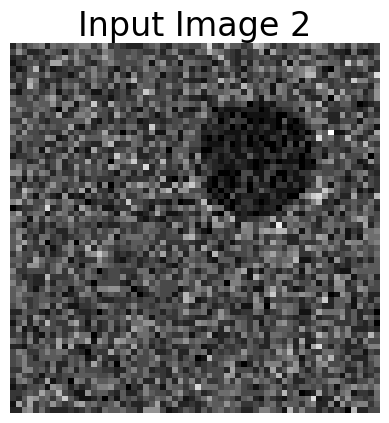

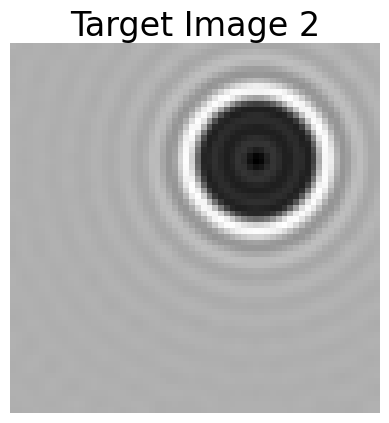

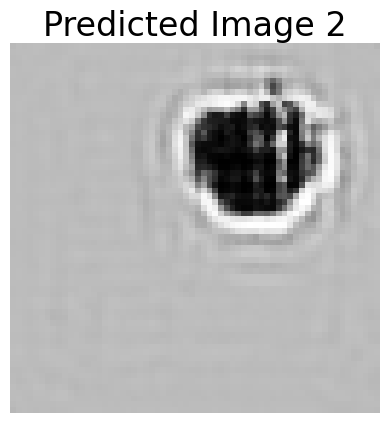

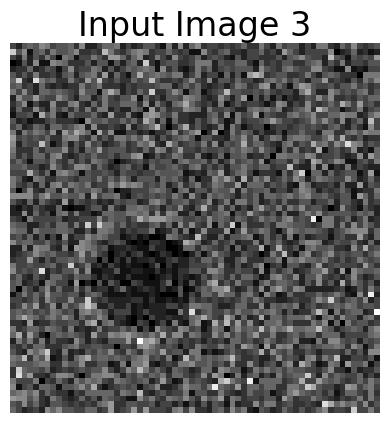

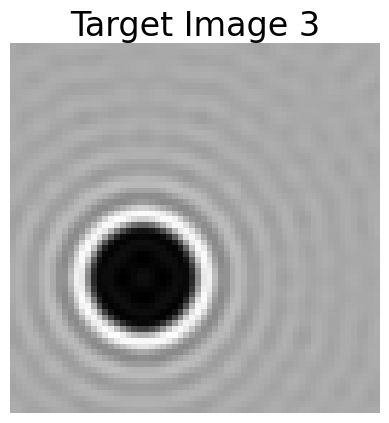

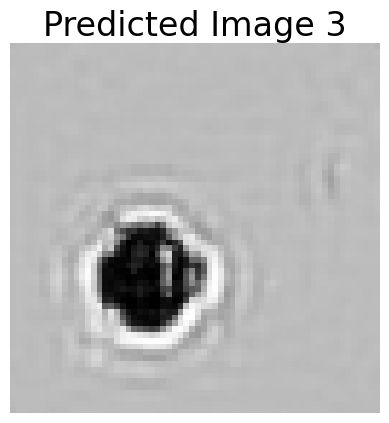

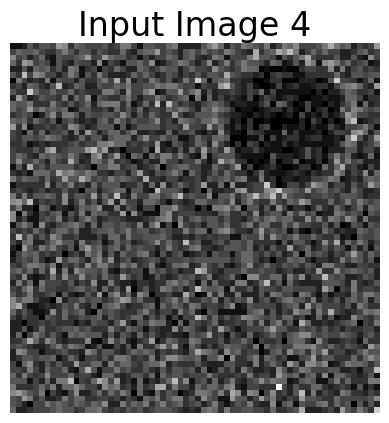

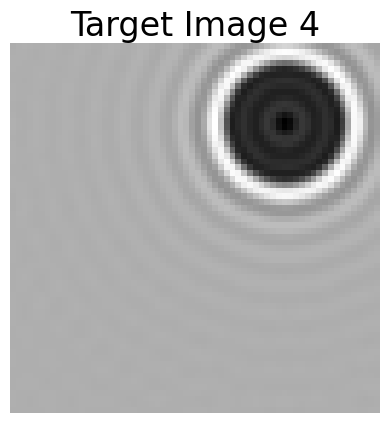

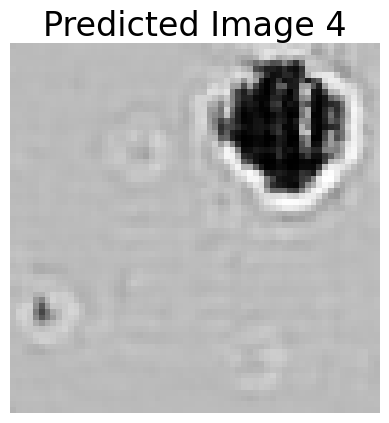

In [13]:
for i in range(5):
    diverse_input, diverse_target = diverse_pipeline.update().resolve()
    diverse_predicted = autoencoder_regressor(diverse_input.unsqueeze(0)).detach()

    plot_image(f"Input Image {i}", diverse_input[0, :, :])
    plot_image(f"Target Image {i}", diverse_target[0, :, :])
    plot_image(f"Predicted Image {i}", diverse_predicted[0, 0, :, :])

We can train on the new dataset.

In [14]:
diverse_dataset = SimulatedDataset(diverse_pipeline, buffer_size=256, replace=0.2)
diverse_loader = DataLoader(diverse_dataset, batch_size=8, shuffle=True)
diverse_autoencoder_regressor = regressor_template.create()
diverse_autoencoder_trainer = dl.Trainer(
    max_epochs=150, accelerator="auto"
)  ### Carlo: 100 seem enough
diverse_autoencoder_trainer.fit(diverse_autoencoder_regressor, diverse_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name          | Type                          | Params
----------------------------------------------------------------
0 | loss          | L1Loss                        | 0     
1 | train_metrics | MetricCollection              | 0     
2 | val_metrics   | MetricCollection              | 0     
3 | test_metrics  | MetricCollection              | 0     
4 | model         | ConvolutionalEncoderDecoder2d | 11.7 K
5 | optimizer     | Adam                          | 0     
-------------------------

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
for i in range(5):
    diverse_input, diverse_target = diverse_pipeline.update().resolve()
    diverse_predicted = diverse_autoencoder_regressor(
        diverse_input.unsqueeze(0)
    ).detach()

    plot_image(f"Input Image {i}", diverse_input[0, :, :])
    plot_image(f"Target Image {i}", diverse_target[0, :, :])
    plot_image(f"Predicted Image {i}", diverse_predicted[0, 0, :, :])

## Improving the predictions
We can use a model with a larger number of activations to improve the results.

In [ ]:
better_autoencoder = dl.ConvolutionalEncoderDecoder2d(
    in_channels=1,
    encoder_channels=[32, 64, 128],
    decoder_channels=[128, 64, 32],
    out_channels=1,
    # out_activation=Sigmoid, ### Carlo: already in the default
)

print(better_autoencoder)

In [ ]:
better_regressor_template = dl.Regressor(
    model=better_autoencoder,
    loss=L1Loss(),
    optimizer=dl.Adam(),
)
better_autoencoder_regressor = better_regressor_template.create()
better_autoencoder_trainer = dl.Trainer(
    max_epochs=100, accelerator="auto"
)  ### BM: 1000 epochs is a bit overkill. doesn't seem to improve much after 200 epochs
### Carlo: I agree
better_autoencoder_trainer.fit(better_autoencoder_regressor, diverse_loader)

In [ ]:
for i in range(5):
    diverse_input, diverse_target = diverse_pipeline.update().resolve()
    diverse_predicted = better_autoencoder_regressor(
        diverse_input.unsqueeze(0)
    ).detach()

    plot_image(f"Input Image {i}", diverse_input[0, :, :])
    plot_image(f"Target Image {i}", diverse_target[0, :, :])
    plot_image(f"Predicted Image {i}", diverse_predicted[0, 0, :, :])